<h1><center><font size="6">Data modeling and evaluation for creditas data set</font></center></h1>

No presente notebook é apresentado o modelagem utilizando desde AutoML com h2o e um algoritmo muito conhecido na atualidade, lightGBM, mediante validação cruzada kfold, k=5, logo avaliaremos os melhores modelos medianto os resultados do CV e no conjunto de test.

**Os dados estão parcialmente desbalanceados.**


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import h2o
import warnings
import lightgbm as lgbm
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from scipy.optimize import differential_evolution
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn import metrics

In [2]:
#Utils
warnings.filterwarnings("ignore")
seed = 1997
number_folds = 5

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print("the dimension of the train data is: {}".format(train.shape))
print("the dimension of the test data is: {}".format(test.shape))

the dimension of the train data is: (10499, 26)
the dimension of the test data is: (4500, 26)


# AutoML com h2o

Podemos usar h2o para treinar os modelos automáticamente e obter o melhor modelo de acordo a alguma métrica tais como o AUC ou o logloss. Algúns modelos como MLG( regressão logistica com regularização), random forest e XGBoost serão testados. Alem disso, podemos obter também as melhores variáveis do modelo mediante a importancia relativa da variável do modelo.

Para os casos de modelos stacked (combinação de varios modelos) e deep learning as descartamos, já que este tipo de modelos são ainda mais complexos de explicar a relação entre variável e target. Usualmente usamos stacking quando queremos mais que nada obter boas predições.

Uma breve explicação sobre os modelos:

* MLG: Neste caso ao ser uma variável binaria, ele utiliza a dsitribuição bernoulli, fazendo que chegue ao modelo de regressão logistico, alem disso apresenta alguma penalizações como l1 e l2 para regularizar os parâmetros a serem estimados.

* Random forest É uma combinação de muitos árvores de decisão utilizando bootstrap(amostragem). A ideia básica de bootstrap é fazer re-amostragem para obter estimadores menos viesados.
* XGBoost Trata-se de um algoritmo do tipo gradient boosting com uma melhor optimização no tempo de treinamento. Gradient Boosting consiste em que cada paso de iteração do algoritmo, estimar mediante arvores os erros dos modelos anteriores até chegar a convergência.

In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpl32p7tz3
  JVM stdout: /tmp/tmpl32p7tz3/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpl32p7tz3/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.3
H2O_cluster_version_age:    22 days
H2O_cluster_name:           H2O_from_python_unknownUser_kuqxyz
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    4 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.6 final
--------------------------  ------------------------------------------------------------------

In [5]:
y_train = train[["id","sent_to_analysis"]].copy().set_index("id")
x_train   = train.drop("sent_to_analysis",axis=1).set_index("id")
y_test = test[["id","sent_to_analysis"]].copy().set_index("id")
x_test   = test.drop("sent_to_analysis",axis=1).set_index("id")
train_h2o = h2o.H2OFrame(train)
x_test_h2o = h2o.H2OFrame(x_test)
x_train_h2o = h2o.H2OFrame(x_train)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
train_columns = train.columns.to_list()
y_column = "sent_to_analysis"
train_h2o[y_column] = train_h2o[y_column].asfactor()

In [7]:
include_algos = ["GLM", "DRF","XGBoost"]
auto_ML = H2OAutoML(max_models=10, seed=seed,nfolds = number_folds,include_algos=include_algos)
auto_ML.train(x=train_columns, y=y_column, training_frame=train_h2o)
leaderboard = auto_ML.leaderboard
print(leaderboard)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 XGBoost_3_AutoML_20201020_232944 0.807733 0.40789 0.563483 0.285354 0.362871 0.131676 
 XGBoost_grid__1_AutoML_20201020_232944_model_2 0.804281 0.414499 0.558546 0.280863 0.365754 0.133776 
 GLM_1_AutoML_20201020_232944 0.798504 0.412625 0.55995 0.290104 0.364197 0.13264 
 DRF_1_AutoML_20201020_232944 0.798013 0.445987 0.555299 0.290397 0.365001 0.133226 
 XGBoost_2_AutoML_20201020_232944 0.79621 0.428537 0.544108 0.289116 0.37203 0.138406 
 XRT_1_AutoML_20201020_232944 0.79611 0.421376 0.553649 0.291036 0.365459 0.133561 
 XGBoost_1_AutoML_20201020_232944 0.789713 0.435325 0.541717 0.292185 0.374286 0.14009 
 XGBoost_grid__1_AutoML_20201020_232944_model_1 0.789213 0.498681 0.535012 0.298983 0.38613 0.149096 
 XGBoost_grid__1_AutoML_20201020_232944_model_3 0.784237 0.461405 0.519458 0.295048 0.38223 0.146099 
 XGBoost_grid__1_AutoML_20201020_232944_model_4 0.780976 0.467781 0.523094 0.300095 0.383339 0.146949

Podemos observar que os melhores modelos são os do tipo XGBoost, utilizaremos o primeiro algoritmo já que apresenta um melhor desempenho na area sobre a curva e um menor logloss.

In [8]:
model_xgboost = h2o.get_model(leaderboard[0,"model_id"])

# LightGBM com CV

LightGBM é um algoritmo do tipo boosting, desenvolvido pela Microsoft. Ultimamente lightGBM tem sido utilizado em muitas competições obtendo bons performance e fazendo competência a XGboost. Outro dos pontos principais é que o tempo de entrenamento é reduzido.
Alguns parâmetros importantes a optimizar são como:
* learning_rate(taxa de aprendizagem do algoritmo)
* num_iterations(número de iterações até convergência)
* l1 e l2 (regularizadores do tipo ridge e lasso - muito útil para variáveis com peso similar)
* max_depth (profundidad do arvore)

Para otimizar podemos usar desde o mais básico como grid_search até mais avanzado como optimização bayesiana ou differential evolution. Neste caso utilizaremos differential evolution mediante validação cruzada e a função a maximizar é o AUC.

In [9]:
def lgbm_optimization(x):
    
    lr = x[0]
    max_depth = int(x[1])
    lambda_l1 = x[2]
    num_itera = int(x[3])
    
    kf = KFold(n_splits=number_folds,shuffle=True,random_state=number_folds)

    train_probsLGBM = []
   
    for i,(a,b) in enumerate(kf.split(x_train,y_train.loc[x_train.index, "sent_to_analysis"])) :
        Xt = x_train.iloc[a,:]
        yt = y_train.loc[Xt.index, "sent_to_analysis"]

        Xv = x_train.iloc[b,:]
        yv = y_train.loc[Xv.index, "sent_to_analysis"]

        learner = LGBMClassifier(learning_rate=lr,max_depth=max_depth,num_iterations=num_itera,
                                    lambda_l1=lambda_l1)

        learner.fit(Xt, yt  , eval_metric="auc",eval_set= [(Xt, yt),(Xv, yv)], verbose=0)


        train_probsLGBM.append(pd.Series(learner.predict_proba(Xv)[:, -1],
                                    index=Xv.index, name="probs"+ str(i)))
        
    train_probsLGBM = pd.concat(train_probsLGBM, axis=1).mean(axis=1)
    
    AUC_cv = metrics.roc_auc_score(y_train, train_probsLGBM.loc[y_train.index,].values)
    return -AUC_cv
    

In [10]:
bounds = [(0, 0.1), (2, 10),(3,30),(100,1000)]
result = differential_evolution(lgbm_optimization, bounds,disp=True,seed=seed)
result.x, result.fun

differential_evolution step 1: f(x)= -0.812484


(array([7.53629828e-02, 3.06709474e+00, 3.23683951e+00, 2.28770318e+02]),
 -0.8124839962086399)

In [11]:
#(array([7.53629828e-02, 3.06709474e+00, 3.23683951e+00, 2.28770318e+02]),
# -0.8124839962086399)

In [12]:
lr = result.x[0]
max_depth = int(result.x[1])
lambda_l1 = result.x[2]
num_iterations = int(result.x[3])
lighgbm_model = LGBMClassifier(learning_rate=lr,max_depth=max_depth,
                               lambda_l1=lambda_l1,num_iterations=num_iterations)

lighgbm_model.fit(x_train, y_train  , eval_metric="auc",verbose=0)

LGBMClassifier(lambda_l1=3.2368395103245007, learning_rate=0.07536298281656238,
               max_depth=3, num_iterations=228)

Alguns pontos a mencionar são:
* Utilizando lightGBM e CV(kfold 5) encontramos os melhores hyperparâmetros maximizando o AUC.
* Assim, temos um modelo que apresenta bons resultados em CV, o modelo usando autoML, e um estimando e otimizado manualmente. 

No próximo passo avaliaremos os dois modelos no conjunto de validação externo.

# Avaliando no conjunto de test
As métricas a usar para comparar são o AUC(area under the curve), o logloss e o f1 score.

Utilizaremos o f1 score já que os dados não estão totalmente balanceados. O f1 score indica a media armonica entre a precisão e o recall do modelo. Um valor proximo a um significa que o modelo consegui diferenciar bem as classes.
O logloss é uma métrica que por não diz nada sobre o ajuste, mas é muito útilo para comparar.


In [13]:
train_probsLGBM = pd.Series(lighgbm_model.predict_proba(x_train)[:, -1],
                                    index=x_train.index, name="probs_lightgbm").loc[y_train.index,].values
train_probsXGB = pd.Series(model_xgboost.predict(x_train_h2o).as_data_frame().iloc[:, -1].to_numpy(),
                                    index=x_train.index, name="probs_XGB").loc[y_train.index,].values

train_classLGBM = pd.Series(lighgbm_model.predict(x_train),
                                    index=x_train.index, name="probs_lightgbm").loc[y_train.index,].values
train_classXGB = pd.Series(model_xgboost.predict(x_train_h2o).as_data_frame().iloc[:, 0].to_numpy(),
                                    index=x_train.index, name="probs_XGB").loc[y_train.index,].values

xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


In [14]:
test_probsLGBM = pd.Series(lighgbm_model.predict_proba(x_test)[:, -1],
                                    index=x_test.index, name="probs_lightgbm").loc[y_test.index,].values
test_probsXGB = pd.Series(model_xgboost.predict(x_test_h2o).as_data_frame().iloc[:, -1].to_numpy(),
                                    index=x_test.index, name="probs_XGB").loc[y_test.index,].values

test_classLGBM = pd.Series(lighgbm_model.predict(x_test),
                                    index=x_test.index, name="probs_lightgbm").loc[y_test.index,].values
test_classXGB = pd.Series(model_xgboost.predict(x_test_h2o).as_data_frame().iloc[:, 0].to_numpy(),
                                    index=x_test.index, name="probs_XGB").loc[y_test.index,].values

xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


In [15]:
LightGBM_AUC_train = metrics.roc_auc_score(y_train, train_probsLGBM).round(4)
LightGBM_logloss_train = metrics.log_loss(y_train, train_probsLGBM).round(4)
LightGBM_f1_score_train = metrics.f1_score(y_train, train_classLGBM).round(4)

LightGBM_AUC_validation = metrics.roc_auc_score(y_test, test_probsLGBM).round(4)
LightGBM_logloss_validation = metrics.log_loss(y_test, test_probsLGBM).round(4)
LightGBM_f1_score_validation = metrics.f1_score(y_test, test_classLGBM).round(4)

XGBoost_AUC_train = metrics.roc_auc_score(y_train, train_probsXGB).round(4)
XGBoost_logloss_train = metrics.log_loss(y_train, train_probsXGB).round(4)
XGBoost_f1_score_train = metrics.f1_score(y_train, train_classXGB).round(4)

XGBoost_AUC_validation = metrics.roc_auc_score(y_test, test_probsXGB).round(4)
XGBoost_logloss_validation = metrics.log_loss(y_test, test_probsXGB).round(4)
XGBoost_f1_score_validation = metrics.f1_score(y_test, test_classXGB).round(4)

In [16]:
dataset = ["train","test"]
LGBM_metrics = {'dataset': ["train","test"], 'auc': [LightGBM_AUC_train, LightGBM_AUC_validation],
          'logloss':[LightGBM_logloss_train,LightGBM_logloss_validation],
           'f1_score':[LightGBM_f1_score_train,LightGBM_f1_score_validation]}
XGB_metrics = {'dataset': ["train","test"], 'auc': [XGBoost_AUC_train, XGBoost_AUC_validation],
          'logloss':[XGBoost_logloss_train,XGBoost_logloss_validation],
           'f1_score':[XGBoost_f1_score_train,XGBoost_f1_score_validation]}

LGBM_metrics = pd.DataFrame(LGBM_metrics)
XGB_metrics = pd.DataFrame(XGB_metrics)

In [17]:
print(f'LightGBM AUC train: {LightGBM_AUC_train}',f'validation: {LightGBM_AUC_validation}')
print(f'LightGBM logloss train: {LightGBM_logloss_train}',f'validation: {LightGBM_logloss_validation}')
print(f'LightGBM f1 score train: {LightGBM_f1_score_train}',f'validation: {LightGBM_f1_score_validation}')
print("\n")
print(f'XGBoost AUC train: {XGBoost_AUC_train}',f'validation: {XGBoost_AUC_validation}')
print(f'XGBoost logloss train: {XGBoost_logloss_train}',f'validation: {XGBoost_logloss_validation}')
print(f'XGBoost f1 score train: {XGBoost_f1_score_train}',f'validation: {XGBoost_f1_score_validation}')


LightGBM AUC train: 0.8456 validation: 0.8337
LightGBM logloss train: 0.377 validation: 0.3868
LightGBM f1 score train: 0.4559 validation: 0.4542


XGBoost AUC train: 0.84 validation: 0.8159
XGBoost logloss train: 0.4107 validation: 0.4341
XGBoost f1 score train: 0.4993 validation: 0.4884


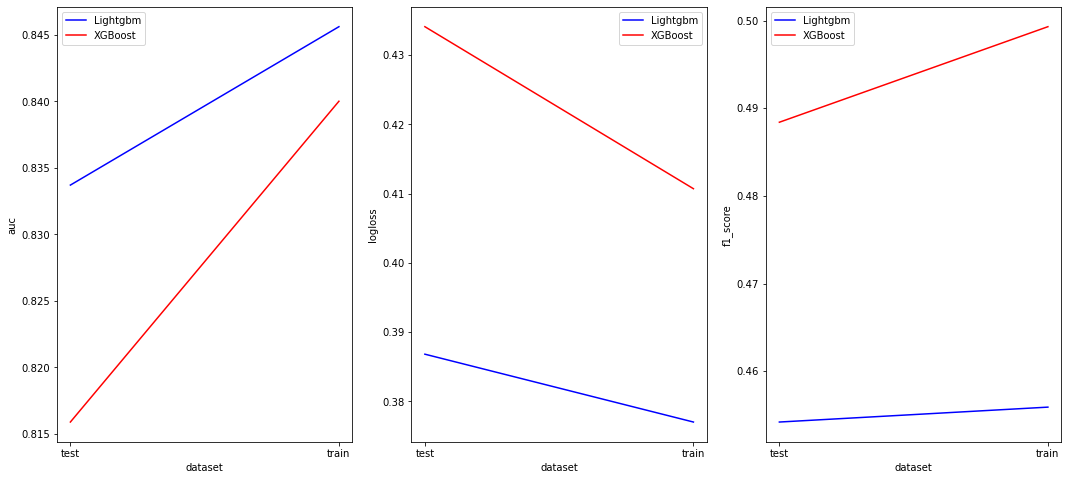

In [18]:
f,ax=plt.subplots(1,3,figsize=(18,8))
sb.lineplot("dataset","auc",data=LGBM_metrics,ax=ax[0],color="blue",label='Lightgbm')
sb.lineplot("dataset","auc",data=XGB_metrics,ax=ax[0],color="red",label='XGBoost')
sb.lineplot("dataset","logloss",data=LGBM_metrics,ax=ax[1],color="blue",label='Lightgbm')
sb.lineplot("dataset","logloss",data=XGB_metrics,ax=ax[1],color="red",label='XGBoost')
sb.lineplot("dataset","f1_score",data=LGBM_metrics,ax=ax[2],color="blue",label='Lightgbm')
sb.lineplot("dataset","f1_score",data=XGB_metrics,ax=ax[2],color="red",label='XGBoost')

# Conclusões dos modelos:
* Podemos apreciar que para um novo conjunto de dados o algoritmo LighGBM tem uma melhor performance que o modelo XGBoost.
* Para o f1 score, podemos apreciar que o modelo XGboost apresenta um melhor performance, mas isso pode acontecer já que o ponte de corte não estaja otimizado para ambos modelos.
*  Chegamos a conclusão que para as métricas escolhidas, o modelo LightGBM obteve um bom performance.


# Top 10 variáveis explanatorias mais importantes

Apresentamos as top 10 variáveis que apresentão um maior peso na variável resposta.

In [19]:
importance_features = pd.Series(lighgbm_model.feature_importances_ / lighgbm_model.feature_importances_.sum(), index=x_train.columns)

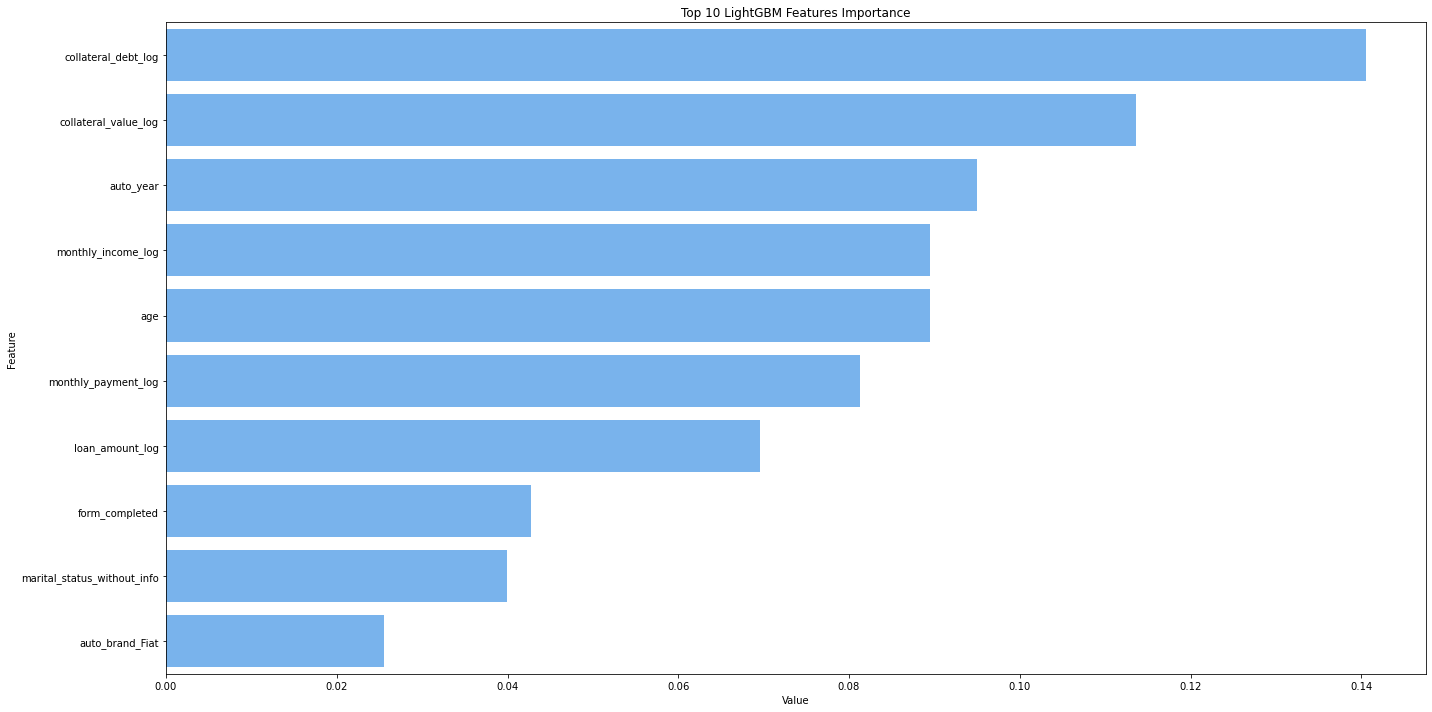

In [20]:
Top_10_features_LGBM = importance_features.sort_values(ascending = False).head(10).reset_index()
Top_10_features_LGBM.columns = ["Feature","Value"]
plt.figure(figsize=(20, 10))
sb.barplot(x="Value", y="Feature", data=Top_10_features_LGBM,color='#66b3ff')
plt.title('Top 10 LightGBM Features Importance')
plt.tight_layout()
plt.show()

# Resíduo vs índice da observação e valor ajustado

Esse gráfico indica se existe alguma dependencia no tempo entre os indices das observações. No presente gráfico podemos apreciar um comportamiento aleatorio, sem nenhuma tendência temporal nas probabilidades indicando um bom ajuste.

Já o gráfico de resíduos vs o valor ajustado nos indica se o modelo está bem ajustado e se existe a presença de valores atípicos. Assim, podemos ver na figura um bom ajuste do modelo proposto.

In [21]:
def get_residual(true_values,predicted_values):
    residual = (-2*np.log(predicted_values))**(1/2)*(train["sent_to_analysis"]==0).astype(int)-(-2*np.log(1-predicted_values))**(1/2)*train["sent_to_analysis"]
    return residual
    

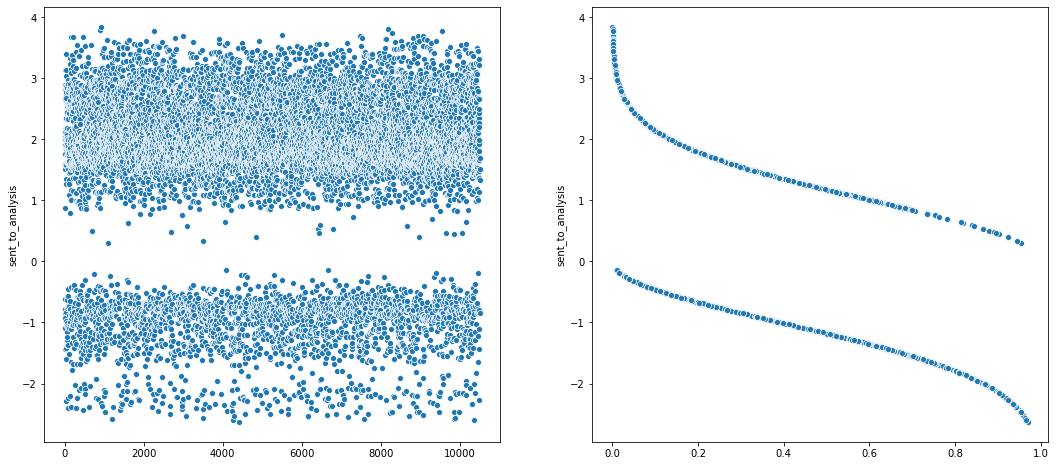

In [22]:
residual = get_residual(y_train,train_probsLGBM)
f,ax=plt.subplots(1,2,figsize=(18,8))
sb.scatterplot(x=train.index.to_numpy(),y=residual,ax=ax[0])
sb.scatterplot(x=train_probsLGBM,y=residual,ax=ax[1])

# Procurando o ponto de corte ótimo

Um ponto importante é de saber se um cliente vai ser enviado para o análise, assim, as probabilidades não são suficiente, precisamos de uma toma de desição para avaliar que pessoa vai para o análise. Assim, apresentamos o ponto de corte ótimo mediante a métrica f1 score avaliado mediante CV.

In [23]:
def get_cutoff(values,cv=number_folds):
    
    result = np.zeros((len(values), 2))
    kf = KFold(n_splits=cv,shuffle=True,random_state=seed)

    train_probsLGBM= []

    for i,(a,b) in enumerate(kf.split(x_train,y_train.loc[x_train.index, "sent_to_analysis"])) :
        Xt = x_train.iloc[a,:]
        yt = y_train.loc[Xt.index, "sent_to_analysis"]

        Xv = x_train.iloc[b,:]
        yv = y_train.loc[Xv.index, "sent_to_analysis"]

        lighgbm_model = LGBMClassifier(learning_rate=lr,max_depth=max_depth,
                               lambda_l1=lambda_l1,num_iterations=num_iterations)

        lighgbm_model.fit(x_train, y_train  , eval_metric="auc",verbose=0)


        train_probsLGBM.append(pd.Series(lighgbm_model.predict_proba(Xv)[:, -1],
                                    index=Xv.index, name="probs"+ str(i)))
        
    train_probsLGBM = pd.concat(train_probsLGBM, axis=1).mean(axis=1).loc[y_train.index,].values
    
    for i, cutoff_i in enumerate(values):
        y_train_pred = (train_probsLGBM>cutoff_i).astype(int)
        f1_score = metrics.f1_score(y_train.values,y_train_pred)
        result[i] = [cutoff_i, f1_score]
    result = pd.DataFrame(result, columns=["cutoff","f1_score"])
    return result

In [24]:
values = np.sort(np.random.uniform(size=10000))
cutoff_data = get_cutoff(values)

Text(0, 0.5, 'f1 score CV')

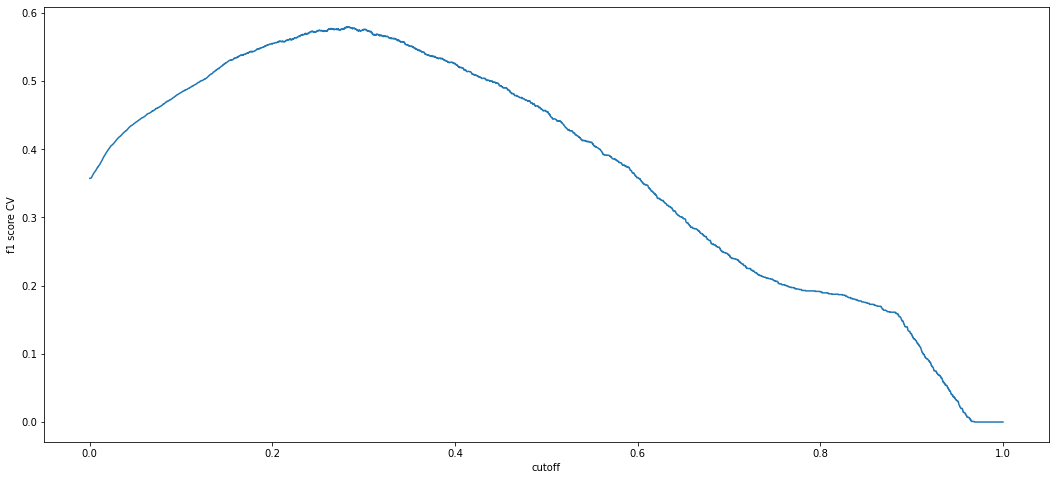

In [25]:
f,ax=plt.subplots(figsize=(18,8))
sb.lineplot(
    data=cutoff_data,
    x="cutoff", y="f1_score")
plt.ylabel('f1 score CV')

In [26]:
cutoff_data.sort_values(by="f1_score",ascending=False).head(1)

cutoff  f1_score
2775  0.283189  0.579861

O ponto de corte é muito melhor que tomando o valor 1/2. Agora podemos ver um aumento de 0.12

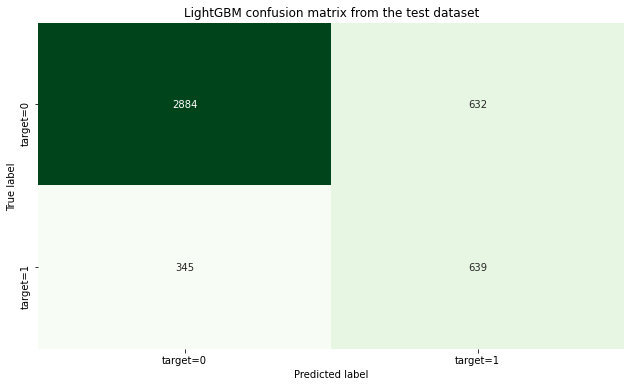

In [27]:
y_test_pred = (test_probsLGBM>0.283).astype(int)
ConfusionMatrix = metrics.confusion_matrix(y_test, y_test_pred) 

ConfusionMatrix = pd.DataFrame(ConfusionMatrix,
                     index = ['target=0','target=1'], 
                     columns = ['target=0','target=1'])

plt.figure(figsize=(10.5,6))
sb.heatmap(ConfusionMatrix, annot=True,cbar=False,cmap="Greens",fmt="d")
plt.title('LightGBM confusion matrix from the test dataset')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Conclusões do modelo:
* Utilizamos AutoML e LightGBM para construir nossos modelos.
* O modelo utilizando LightGBM apresentou um melhor performance no conjunto de CV, train e test.
* O ponto de corte ótimo seria de 0.283 para nosso modelo LightGBM, isso mediante maximizando o f1 score.
* Não existe problemas com autocorrelação no modelo, indicando um bom ajuste

In [28]:
lighgbm_model.booster_.save_model('creditas_lgbm_sent_analysis.txt')